In [40]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers


In [2]:
dataset_path = keras.utils.get_file("GOOG.csv", "http://localhost:8000/data/daily/GOOG.csv")

column_names = ['Date','Open','High','Low','Close','Adj Close','Volume'] 
raw_dataset = pd.read_csv(dataset_path, 
#                           names=column_names, 
                          dtype={'Close': np.float64,'Open': np.float64,'High': np.float64,'Adj Close': np.float64, 'Volume': np.float64},
                          header=0,
                          na_values = "?", 
                          comment='\t',
                          sep=",",
                          skipinitialspace=True)


dataset = raw_dataset.copy()
dataset = dataset.sort_values(by=['Date'],ascending=False)
test_dataset = dataset[0:700]
train_dataset = dataset[700:]

In [3]:
print len(dataset)
print len(train_dataset)
print len(test_dataset)
train_dataset.head(5)

3534
2834
700


,Date,Open,High,Low,Close,Adj Close,Volume
2833,2015-11-18,727.580017,741.409973,727.000000,740.000000,740.000000,1684300.0
2832,2015-11-17,729.289978,731.844971,723.026978,725.299988,725.299988,1510900.0
2831,2015-11-16,715.599976,729.489990,711.330017,728.960022,728.960022,1905900.0
2830,2015-11-13,729.169983,731.150024,716.729980,717.000000,717.000000,2075500.0
2829,2015-11-12,731.000000,737.799988,728.645020,731.229980,731.229980,1837200.0


In [4]:
train_stats = train_dataset.describe()
train_stats.pop("Close")
train_stats = train_stats.transpose()
train_stats



,count,mean,std,min,25%,50%,75%,max
Open,2834.0,3.081928e+02,1.464132e+02,49.274517,2.116087e+02,2.717326e+02,3.774848e+02,7.324600e+02
High,2834.0,3.111213e+02,1.472027e+02,50.541279,2.136504e+02,2.747133e+02,3.803971e+02,7.414100e+02
Low,2834.0,3.049268e+02,1.453642e+02,47.669952,2.090156e+02,2.685956e+02,3.754058e+02,7.302300e+02
Adj Close,2834.0,3.080442e+02,1.463329e+02,49.681866,2.116199e+02,2.715414e+02,3.780859e+02,7.400000e+02
Volume,2834.0,9.110012e+06,8.626936e+06,7900.000000,3.862450e+06,6.274700e+06,1.188605e+07,8.276810e+07


In [86]:
# Create features (only close price for now)
def convert_to_percentage(old, new):
    return (old - new) / old

def convert_to_train(raw_dataset):
    dataset = raw_dataset.copy()
    features = []
    labels = []
    for i in range(5, len(dataset) - 50):

        feature_dataset = dataset[i:i+50].copy()
        latest_close = feature_dataset['Close'].iloc[0]
        
        features.append(
            feature_dataset['Close']
                .map(lambda current: convert_to_percentage(latest_close, current))
                .tolist()
        )
        labels.append([
            dataset['Close'].iloc[i-1] / latest_close,
            #dataset['Close'].iloc[i-5] / latest_close,
        ])
    return [features,labels]
converted_feature_set = convert_to_train(dataset)

#dset = test_dataset.sort_values(by=['Date'],ascending=False)[0:10]
# for each date, calculate the percentage change of each value from the current close
#dset['Close']

In [112]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(converted_feature_set[0][0])]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse','accuracy'])
  return model

In [113]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65        
Total params: 7,489
Trainable params: 7,489
Non-trainable params: 0
_________________________________________________________________


In [129]:
#len(converted_feature_set[0][0])
train_data = np.array(converted_feature_set[0][900:])
train_labels = np.array(converted_feature_set[1][900:])

test_data = np.array(converted_feature_set[0][:900])
test_labels = np.array(converted_feature_set[1][:900])
history = model.fit(
  train_data, train_labels,
  epochs=500, validation_split = 0.2, verbose=0)

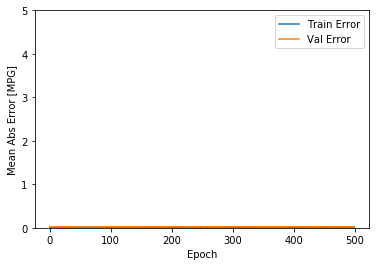

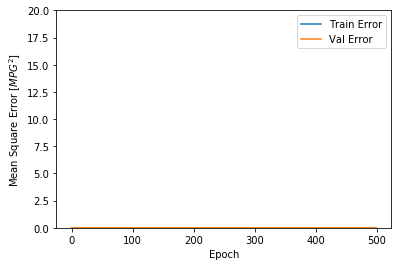

In [130]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,20])

plot_history(history)


In [131]:
loss, mae, mse, accuracy = model.evaluate(test_data, test_labels, verbose=0)

mse

0.00021824973693583162

In [132]:
mae

0.010743256873554654

In [133]:
mse

0.00021824973693583162

In [134]:
loss

0.00021824973693583162

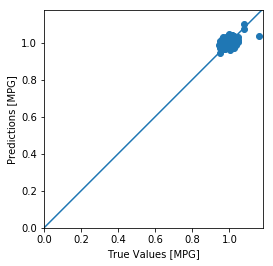

In [135]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")